# Classic ML Model Building Notebook - Word Modeling

## Import Packages

In [2]:
# Audio processing
import librosa
import librosa.display as ld
import IPython.display as ipd
# Data cleaning
import os
import pandas as pd
import numpy as np
from numpy import mean, var
# Data visualization
import matplotlib.pyplot as plt
# Machine learning
import sklearn
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Advanced options
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
import pickle

--------------

------------------

## Define Constants

In [3]:
FRAMESIZE = 1024
HOPLENGTH = 512
# 13 mels for fingerprint and more than 20 mels for word detection
MELS = 13 
SPLITFREQ = 2000
PCA_N = 2

-------------

----------

## Read Data

In [4]:
df_small_chunk = pd.read_csv('A:\OpenSesame\data\\small_chunk_speaker.csv')
df_big_chunk = pd.read_csv('A:\OpenSesame\data\\big_chunk_speaker.csv')

xs_features = np.array(df_small_chunk.iloc[:,:])
xb_features = np.array(df_big_chunk.iloc[:,:])
xs_features

array([[ 2.74171082e+02, -5.91251709e+02,  1.22773174e+04,
         2.78430246e-02,  2.08723382e-03],
       [ 3.39712433e+02, -5.96309570e+02,  1.33797646e+04,
         3.36477980e-02,  4.33203066e-03],
       [ 3.02544525e+02, -5.95602173e+02,  1.16577363e+04,
         2.33854018e-02,  1.25041464e-03],
       [ 3.45469208e+02, -5.46374390e+02,  9.22018359e+03,
         5.19323051e-02,  2.08905824e-02],
       [ 3.10062164e+02, -5.86068176e+02,  1.17619922e+04,
         2.37353239e-02,  1.03716541e-03],
       [ 2.60364441e+02, -5.98186096e+02,  8.15981641e+03,
         1.91031303e-02,  7.75156135e-04],
       [ 3.07157806e+02, -5.86749390e+02,  1.25159707e+04,
         2.56977230e-02,  1.60632515e-03],
       [ 3.11788788e+02, -5.93493591e+02,  1.47705400e+04,
         2.47365441e-02,  2.15951540e-03],
       [ 2.54355682e+02, -6.07461975e+02,  5.96504248e+03,
         1.51092345e-02,  6.33152551e-04],
       [ 3.46405548e+02, -5.71864380e+02,  1.35127031e+04,
         4.25694622e-02

In [5]:
y_features = pd.read_csv('A:\OpenSesame\data\\target_data_speaker.csv')
y_features = np.array(y_features.iloc[:,:])

In [6]:
best_features_small = list(np.loadtxt(open('A:\OpenSesame\data\\speaker_features_small.csv'), delimiter=",", dtype='str'))
best_features_big = list(np.loadtxt(open('A:\OpenSesame\data\\speaker_features_big.csv'), delimiter=",", dtype='str'))
best_features_small

['feature 1', 'feature 2', 'feature 3', 'feature 6', 'feature 7']

In [7]:
xb_features.shape

(115, 5)

------

-----------

## Data Modeling

- We will model the data with those five classifiers:
    - Logistic Regression
    - XGBoost
    - SVM
    - Random Forest 
- And we will model the Big-Chunk-Data vs Small-Chunk-Data and compare between them.

### Hyperparameters Tuning

In [8]:
xs_train, xs_test, y_train, y_test = train_test_split(xs_features, y_features, test_size=0.3)
xb_train, xb_test, y_train, y_test = train_test_split(xb_features, y_features, test_size=0.3)

1- Logistic Regression

In [8]:
# # Small chunk 
# LR = LogisticRegression()
# LRparam_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'penalty': ['l1', 'l2'],
#     # 'max_iter': list(range(100,800,100)),
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# }
# LR_search = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 3, cv=5)

# # fitting the model for grid search 
# LR_search.fit(xs_train , y_train)
# LR_search.best_params_
# # summarize
# print('Mean Accuracy: %.3f' % LR_search.best_score_)
# print('Config: %s' % LR_search.best_params_)

In [9]:
# # Big chunk 
# LR = LogisticRegression()
# LRparam_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'penalty': ['l1', 'l2'],
#     # 'max_iter': list(range(100,800,100)),
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# }
# LR_search = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 3, cv=5)

# # fitting the model for grid search 
# LR_search.fit(xb_train , y_train)
# LR_search.best_params_
# # summarize
# print('Mean Accuracy: %.3f' % LR_search.best_score_)
# print('Config: %s' % LR_search.best_params_)

- LR Hyperparameters:
    - Small-chunk {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
    - Big-chunk {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

-----

2- XGBoost

In [10]:
# # Small chunk
# def random_search_tuning():
#     # define the train set and test set
#     x_train, x_val, y_train, y_val = train_test_split(xs_features, y_features, test_size=0.05)
#     print("Shapes - X_train: ", x_train.shape,
#           ", X_val: ", x_val.shape, ", y_train: ",
#           y_train.shape, ", y_val: ", y_val.shape)

#     params = {'max_depth': [3, 6, 10, 15],
#               'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
#               'subsample': np.arange(0.5, 1.0, 0.1),
#               'colsample_bytree': np.arange(0.5, 1.0, 0.1),
#               'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
#               'n_estimators': [100, 250, 500, 750],
#               'num_class': [10]
#               }

#     xgbclf = XGBClassifier(objective="multi:softmax", tree_method='hist', random_state=0)
#     clf = RandomizedSearchCV(estimator=xgbclf,
#                              param_distributions=params,
#                              scoring='accuracy',
#                              n_iter=25,
#                              n_jobs=4,
#                              verbose=1)

#     clf.fit(x_train, y_train)

#     best_combination = clf.best_params_

#     return best_combination


# best_params = random_search_tuning()
# print("Best hyperparameter combination: ", best_params)

In [11]:
# # Big chunk
# def random_search_tuning():
#     # define the train set and test set
#     x_train, x_val, y_train, y_val = train_test_split(xb_features, y_features, test_size=0.05)
#     print("Shapes - X_train: ", x_train.shape,
#           ", X_val: ", x_val.shape, ", y_train: ",
#           y_train.shape, ", y_val: ", y_val.shape)

#     params = {'max_depth': [3, 6, 10, 15],
#               'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
#               'subsample': np.arange(0.5, 1.0, 0.1),
#               'colsample_bytree': np.arange(0.5, 1.0, 0.1),
#               'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
#               'n_estimators': [100, 250, 500, 750],
#               'num_class': [10]
#               }

#     xgbclf = XGBClassifier(objective="multi:softmax", tree_method='hist', random_state=0)
#     clf = RandomizedSearchCV(estimator=xgbclf,
#                              param_distributions=params,
#                              scoring='accuracy',
#                              n_iter=25,
#                              n_jobs=4,
#                              verbose=1)

#     clf.fit(x_train, y_train)

#     best_combination = clf.best_params_

#     return best_combination


# best_params = random_search_tuning()
# print("Best hyperparameter combination: ", best_params)

- XGBoost Hyperparameters:
    - Small chunk {'subsample': 0.7999999999999999, 'num_class': 10, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.3, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.7}
    - Big chunk {'subsample': 0.7999999999999999, 'num_class': 10, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.5}

---------

3- SVM

In [12]:
# # Small-chunk
# parameters = {
#     "kernel": ["linear","rbf"],
#     "C":[0.1,1,10]
# }

# svm = SVC()
# cv = GridSearchCV(svm,parameters,cv=5)
# cv.fit(xs_features,y_features) 

# def display(results):
#     print(f'Best parameters are: {results.best_params_}')
#     mean_score = results.cv_results_['mean_test_score']
#     std_score = results.cv_results_['std_test_score']
#     params = results.cv_results_['params']
#     for mean,std,params in tqdm(zip(mean_score,std_score,params)):
#         print(f'{round(mean,2)} + or -{round(std,2)} for the {params}')

# display(cv)

In [13]:
# # Big-chunk
# parameters = {
#     "kernel": ["linear","rbf"],
#     "C":[0.1,1,10]
# }

# svm = SVC()
# cv = GridSearchCV(svm,parameters,cv=5)
# cv.fit(xb_features,y_features) 

# def display(results):
#     print(f'Best parameters are: {results.best_params_}')
#     mean_score = results.cv_results_['mean_test_score']
#     std_score = results.cv_results_['std_test_score']
#     params = results.cv_results_['params']
#     for mean,std,params in tqdm(zip(mean_score,std_score,params)):
#         print(f'{round(mean,2)} + or -{round(std,2)} for the {params}')

# display(cv)

- SVM hyperparameters
    - Small chunk {'C': 0.1, 'kernel': 'linear'}
    - Big chunk {'C': 1, 'kernel': 'linear'}

-----

4- Random Forest

In [14]:
# # Small-chunk
# # Number of trees in random forest
# n_estimators = [int(x) for x in range(200,2000,200)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(xs_train, y_train)


# def evaluate(model, test_features, test_labels):
#     y_pred = model.predict(test_features)
#     accuracy = accuracy_score(y_test, y_pred)
#     print (accuracy)
#     print(confusion_matrix(y_test,y_pred))
    

# best_random = rf_random.best_estimator_
# evaluate(best_random, xs_test, y_test)

# print(rf_random.best_params_)

In [15]:
# # Big-chunk
# # Number of trees in random forest
# n_estimators = [int(x) for x in range(200,2000,200)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(xb_train, y_train)


# def evaluate(model, test_features, test_labels):
#     y_pred = model.predict(test_features)
#     accuracy = accuracy_score(y_test, y_pred)
#     print (accuracy)
#     print(confusion_matrix(y_test,y_pred))
    

# best_random = rf_random.best_estimator_
# evaluate(best_random, xb_test, y_test)

# print(rf_random.best_params_)

- Random Forest Hyperparameters
    - Small chunk {'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
    - Big chunk {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}

--------------

### Model Selection

In [16]:
def train_model(model, x_features, y_features, pca='yes', chunk='small'):
    
    x_train, x_test, y_train, y_test = train_test_split(x_features, y_features, test_size=0.3)
    sc = StandardScaler()
    pca = PCA(n_components = PCA_N)
    
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    
    if pca == 'yes':
        x_train = pca.fit_transform(x_train)
        x_features = pca.fit_transform(x_features)
        x_test = pca.transform(x_test)
    
    model.fit(x_train, y_train.ravel())
    y_pred = model.predict(x_test)
    
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, model.predict(x_test))
    score = cross_val_score(model, x_features, y_features, cv=KFold(n_splits=15))
        
    print(f'Model Accuracy = {accuracy}\n Confusion Matrix = {cm} \n Avg Cross Validation Score = {score.mean()}')
    
    return model

#### Small Chunk Data

In [17]:
lrs = LogisticRegression(random_state = 0, C = 1000, penalty = 'l1', solver = 'liblinear')
xgbs = XGBClassifier(objective="multi:softmax", tree_method='hist', random_state=0, subsample = 0.7999999999999999, num_class = 10, n_estimators = 500, max_depth = 10, learning_rate = 0.3, colsample_bytree = 0.7999999999999999, colsample_bylevel = 0.7)
svms = SVC(C=0.1, kernel='linear', random_state = 0)
rfs = RandomForestClassifier(random_state = 0, n_estimators=1800, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=30, bootstrap=False)

In [18]:
# without PCA
print(f"Logistic Regression without PCA \n")
lr_s = train_model(lrs, xs_features, y_features)
     
print('\n')
# with PCA
print(f"Logistic Regression with PCA \n")
lr_s = train_model(lrs, xs_features, y_features, pca='yes')

Logistic Regression without PCA 

Model Accuracy = 0.4857142857142857
 Confusion Matrix = [[3 1 1 0 0]
 [4 2 0 2 0]
 [3 0 4 0 3]
 [0 0 1 2 1]
 [1 0 1 0 6]] 
 Avg Cross Validation Score = 0.5321428571428571


Logistic Regression with PCA 

Model Accuracy = 0.6571428571428571
 Confusion Matrix = [[5 1 2 1 0]
 [1 3 1 0 1]
 [0 3 4 0 0]
 [0 0 1 6 0]
 [0 1 0 0 5]] 
 Avg Cross Validation Score = 0.5321428571428571


In [19]:
y_features.shape

(115, 1)

In [20]:
# without PCA
print(f"XGBoost without PCA \n")
xgb_s = train_model(xgbs, xs_features, y_features)

print('\n')
# with PCA
print(f"XGBoost with PCA \n")
xgb_s = train_model(xgbs, xs_features, y_features, pca='yes')

XGBoost without PCA 

Model Accuracy = 0.7714285714285715
 Confusion Matrix = [[8 0 0 0 0]
 [0 3 1 0 0]
 [0 2 9 0 0]
 [1 0 4 4 0]
 [0 0 0 0 3]] 
 Avg Cross Validation Score = 0.6761904761904761


XGBoost with PCA 

Model Accuracy = 0.6857142857142857
 Confusion Matrix = [[5 1 0 0 0]
 [0 4 1 3 0]
 [0 2 6 0 0]
 [1 1 0 5 1]
 [1 0 0 0 4]] 
 Avg Cross Validation Score = 0.6761904761904761


In [21]:
# without PCA
print(f"SVM without PCA \n")
svm_s = train_model(svms, xs_features, y_features)


print('\n')
# with PCA
print(f"SVM with PCA \n")
svm_s = train_model(svms, xs_features, y_features, pca='yes')

SVM without PCA 

Model Accuracy = 0.5142857142857142
 Confusion Matrix = [[8 0 0 0 3]
 [0 3 0 1 0]
 [0 4 0 6 0]
 [0 1 0 2 0]
 [0 2 0 0 5]] 
 Avg Cross Validation Score = 0.4261904761904762


SVM with PCA 

Model Accuracy = 0.4
 Confusion Matrix = [[4 0 1 0 3]
 [0 0 5 0 2]
 [0 0 5 0 0]
 [0 0 7 0 0]
 [0 0 3 0 5]] 
 Avg Cross Validation Score = 0.4261904761904762


In [22]:
# without PCA
print(f"Random Forest without PCA \n")
rf_s = train_model(rfs, xs_features, y_features)


print('\n')
# with PCA
print(f"Random Forest with PCA \n")
rf_s = train_model(rfs, xs_features, y_features, pca='yes')

Random Forest without PCA 

Model Accuracy = 0.7428571428571429
 Confusion Matrix = [[12  1  0  0  0]
 [ 0  3  0  0  0]
 [ 0  1  6  2  0]
 [ 0  1  1  3  0]
 [ 0  3  0  0  2]] 
 Avg Cross Validation Score = 0.6321428571428573


Random Forest with PCA 

Model Accuracy = 0.6285714285714286
 Confusion Matrix = [[7 1 0 0 1]
 [0 1 1 0 2]
 [0 1 4 0 0]
 [0 2 2 4 0]
 [0 1 2 0 6]] 
 Avg Cross Validation Score = 0.6321428571428573


#### Big Chunk Data

In [23]:
lrb = LogisticRegression(random_state = 0, C = 100, penalty = 'l1', solver = 'liblinear')
xgbb = XGBClassifier(objective="multi:softmax", tree_method='hist', random_state=0, subsample = 0.7999999999999999, num_class = 10, n_estimators = 100, max_depth = 15, learning_rate = 0.01, colsample_bytree = 0.6, colsample_bylevel = 0.5)
svmb = SVC(C=1, kernel='linear', random_state = 0)
rfb = RandomForestClassifier(random_state = 0, n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=50, bootstrap=True)

In [24]:
# without PCA
print(f"Logistic Regression without PCA \n")
lr_b = train_model(lrb, xb_features, y_features, chunk='big')
     
print('\n')
# with PCA
print(f"Logistic Regression with PCA \n")
lr_b = train_model(lrb, xb_features, y_features, pca='yes', chunk='big')

Logistic Regression without PCA 

Model Accuracy = 0.5142857142857142
 Confusion Matrix = [[5 0 0 0 0]
 [1 1 3 5 0]
 [0 0 6 1 0]
 [2 0 1 3 0]
 [0 0 2 2 3]] 
 Avg Cross Validation Score = 0.5892857142857143


Logistic Regression with PCA 

Model Accuracy = 0.8285714285714286
 Confusion Matrix = [[9 0 0 0 0]
 [0 5 0 0 1]
 [0 0 5 0 2]
 [0 2 0 3 0]
 [0 0 1 0 7]] 
 Avg Cross Validation Score = 0.5892857142857143


In [25]:
# without PCA
print(f"XGBoost without PCA \n")
xgb_b = train_model(xgbb, xb_features, y_features, chunk='big')

print('\n')
# with PCA
print(f"XGBoost with PCA \n")
xgb_b = train_model(xgbb, xb_features, y_features, pca='yes', chunk='big')

XGBoost without PCA 

Model Accuracy = 0.7428571428571429
 Confusion Matrix = [[11  0  0  0  0]
 [ 0  2  1  1  1]
 [ 0  1  5  0  0]
 [ 0  3  0  2  1]
 [ 0  0  0  1  6]] 
 Avg Cross Validation Score = 0.6916666666666667


XGBoost with PCA 

Model Accuracy = 0.7428571428571429
 Confusion Matrix = [[10  0  0  0  0]
 [ 0  4  1  2  0]
 [ 0  2  5  2  0]
 [ 0  0  0  2  0]
 [ 0  0  0  2  5]] 
 Avg Cross Validation Score = 0.6916666666666667


In [26]:
# without PCA
print(f"SVM without PCA \n")
svm_b = train_model(svmb, xb_features, y_features, chunk='big')


print('\n')
# with PCA
print(f"SVM with PCA \n")
svm_b = train_model(svmb, xb_features, y_features, pca='yes', chunk='big')

SVM without PCA 

Model Accuracy = 0.5714285714285714
 Confusion Matrix = [[7 0 6 0 0]
 [0 3 1 0 1]
 [0 2 5 0 0]
 [0 0 3 1 1]
 [0 1 0 0 4]] 
 Avg Cross Validation Score = 0.6226190476190477


SVM with PCA 

Model Accuracy = 0.5714285714285714
 Confusion Matrix = [[4 0 0 0 0]
 [0 4 1 0 3]
 [0 1 6 0 0]
 [0 2 7 0 0]
 [0 0 1 0 6]] 
 Avg Cross Validation Score = 0.6226190476190477


In [27]:
# without PCA
print(f"Random Forest without PCA \n")
rf_b = train_model(rfb, xb_features, y_features, chunk='big')


print('\n')
# with PCA
print(f"Random Forest with PCA \n")
rf_b = train_model(rfb, xb_features, y_features, pca='yes', chunk='big')

Random Forest without PCA 

Model Accuracy = 0.7428571428571429
 Confusion Matrix = [[7 0 0 0 0]
 [0 2 1 2 1]
 [1 0 8 1 0]
 [0 1 1 4 0]
 [0 0 0 1 5]] 
 Avg Cross Validation Score = 0.6904761904761904


Random Forest with PCA 

Model Accuracy = 0.7142857142857143
 Confusion Matrix = [[9 0 0 0 0]
 [0 4 1 0 1]
 [0 4 5 0 0]
 [0 4 0 4 0]
 [0 0 0 0 3]] 
 Avg Cross Validation Score = 0.6904761904761904


---------

### Model Building

- As the best model is the Small-chunk-PCA-Random Forest model

Implementation and a little visualization to see our Random Forest Model

In [9]:
# Split big-chunk-data into (70%) train data and (30%) test data
xb_train, xb_test, y_train, y_test = train_test_split(xb_features, y_features, test_size=0.3)

In [10]:
# performing preprocessing part
sc = StandardScaler()
  
# xs_train = sc.fit_transform(xs_train)
# xs_test = sc.transform(xs_test)

xb_train = sc.fit_transform(xb_train)
xb_test = sc.transform(xb_test)

# print(xs_train.shape)
print(xb_train.shape)

#-----------------------------------------------

pca = PCA(n_components = PCA_N)
# xs_train_pca = pca.fit_transform(xs_train)
# xs_test_pca = pca.transform(xs_test)

xb_train_pca = pca.fit_transform(xb_train)
xb_test_pca = pca.transform(xb_test)

(80, 5)


In [15]:
# classifier = LogisticRegression(random_state = 0, C = 100, penalty = 'l1', solver = 'liblinear')
# classifier = SVC(C=1, kernel='linear', random_state = 0)
# classifier = RandomForestClassifier(random_state = 0, n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=50, bootstrap=True)
# classifier = XGBClassifier(objective="multi:softmax", tree_method='hist', random_state=0, subsample = 0.7999999999999999, num_class = 10, n_estimators = 100, max_depth = 15, learning_rate = 0.01, colsample_bytree = 0.6, colsample_bylevel = 0.5)
# classifier.fit(xb_train_pca, y_train)
# classifier

In [16]:
classifier_path = 'A:\\OpenSesame\\models\\rf_speaker.pkl'
classifier = pickle.load(open(classifier_path, 'rb'))

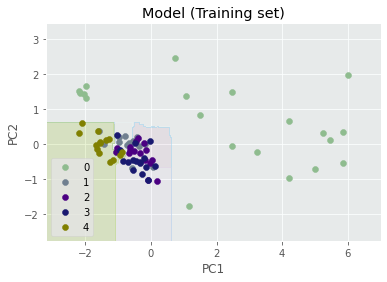

In [25]:
# Predicting the training set
# result through scatter plot 
from matplotlib.colors import ListedColormap
  
X_set, y_set = xb_train_pca, y_train[:,0]
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                     stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1,
                     stop = X_set[:, 1].max() + 1, step = 0.01))
  
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(),
             X2.ravel()]).T).reshape(X1.shape), alpha = 0.2,
             cmap = ListedColormap(('azure', 'deepskyblue','thistle','lavender', 'yellowgreen')))
  
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
  
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color = ListedColormap(('darkseagreen', 'slategray', 'indigo', 'midnightblue', 'olive'))(i), label = j)
  
plt.title('Model (Training set)')
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend() # to show legend
plt.style.use('ggplot')  
# show scatter plot
plt.show()

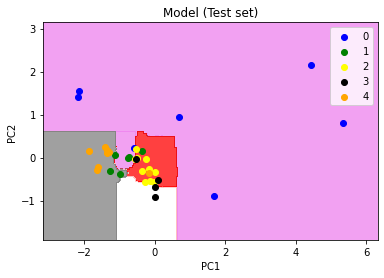

In [18]:
# Visualising the Test set results through scatter plot
from matplotlib.colors import ListedColormap
  
X_set, y_set = xb_test_pca, y_test[:,0]
  
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                     stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1,
                     stop = X_set[:, 1].max() + 1, step = 0.01))
  
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(),
             X2.ravel()]).T).reshape(X1.shape), alpha = 0.75,
             cmap = ListedColormap(('violet', 'brown','red','white', 'grey')))
  
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
  
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color = ListedColormap(('blue', 'green', 'yellow', 'black', 'orange'))(i), label = j)
  
# title for scatter plot
plt.title('Model (Test set)') 
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend()
plt.style.use('ggplot')    
# show scatter plot
plt.show()

------------

### Model verification

In [77]:
# Functions we will use
def transform_audio(audio, FRAMESIZE, HOPLENGTH, MELS, SPLITFREQ):
    
    audio_array, sr = librosa.load(audio)
    ae_audio = fancy_amplitude_envelope(audio_array, FRAMESIZE, HOPLENGTH)
    rms_audio = librosa.feature.rms(audio_array, frame_length=FRAMESIZE, hop_length=HOPLENGTH)[0]
    mel_audio = librosa.feature.melspectrogram(audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH, n_mels=MELS)
    log_mel_audio = librosa.power_to_db(mel_audio)[0]
    mfccs_audio = librosa.feature.mfcc(y=audio_array, n_mfcc=MELS, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)[0]
    sc_audio = librosa.feature.spectral_centroid(y=audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)[0]
    chromagram_audio = librosa.feature.chroma_stft(audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)[0]
    tone_audio = librosa.feature.tonnetz(y=audio_array, sr=sr)[0]
    
#     return np.hstack((log_mel_audio, mfccs_audio, sc_audio, rms_audio, ae_audio, chromagram_audio, tone_audio))
    return np.hstack((mean(log_mel_audio), var(log_mel_audio), mean(mfccs_audio), var(mfccs_audio), mean(sc_audio), var(sc_audio), mean(ae_audio), var(ae_audio), mean(chromagram_audio), var(chromagram_audio), mean(tone_audio), var(tone_audio)))


def fancy_amplitude_envelope(signal, framesize, hoplength):
    return np.array([max(signal[i:i+framesize]) for i in range(0, len(signal), hoplength)])

In [78]:
x_ver_features = []
for x in best_features_big:
    x_ver_features.append(int(x.split(' ')[1]))
x_ver_features

# x_ver_features = []
# for x in best_features_small:
#     x_ver_features.append(int(x.split(' ')[1]))
# x_ver_features

[1, 2, 3, 4, 6]

In [79]:
def test_classifier(path):
    file_paths = f"A:\\Professional\\Engineering CU\\DSP_Data_Verification\\{path}\\"
    for file in os.listdir(file_paths):
        audio = file_paths+file
        x_ver = transform_audio(audio, FRAMESIZE*4, HOPLENGTH*4, MELS, SPLITFREQ) #Big-chunk
        x_ver = x_ver[x_ver_features]
        x_ver = sc.transform(x_ver.reshape(1,-1))
        x_ver = pca.transform(x_ver)[0]
        
        print(file)
        print(classifier.predict(np.array([x_ver[0].ravel(), x_ver[1].ravel()]).T).reshape(x_ver[0].shape))

In [86]:
test_classifier('open the door')

ahmed_otd13.wav
2
ahmed_otd2.wav
3
maha_otd13.wav
4
maha_otd14.wav
4
mahmoud_otd10.wav
2
mahmoud_otd11.wav
2
mahmoud_otd12.wav
2
mahmoud_otd13.wav
2
mahmoud_otd14.wav
3
mahmoud_otd9.wav
2


In [87]:
dest = "A:\OpenSesame\models\\"
picklefile = "rf_speaker"
pickle.dump(classifier,open(dest + picklefile+'.pkl','wb'))
# classifier.save_model(dest+picklefile+'.json')